# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

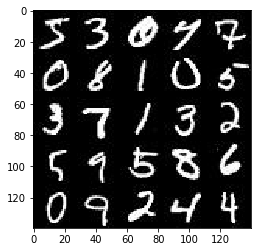

In [2]:
import helper

data_dir = './data'

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

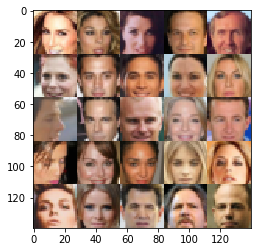

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(alpha * x1, x1)
        d1 = tf.nn.dropout(relu1, 0.5)
        # 14x14x64
        
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        d2 = tf.nn.dropout(relu2, 0.5)
        # 7x7x128
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        d3 = tf.nn.dropout(relu3, 0.5)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(d3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        d1 = tf.nn.dropout(x1, 0.5)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(d1, 256, 5, strides=2, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        d2 = tf.nn.dropout(x2, 0.5)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(d2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        d3 = tf.nn.dropout(x3, 0.5)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(d3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model 
    alpha = 0.12
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_tf = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    current_step = 0
    print_loss_every = 10
    show_image_every = 500
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.8590... Generator Loss: 0.6340
Epoch 0/2... Discriminator Loss: 1.9317... Generator Loss: 1.0176
Epoch 0/2... Discriminator Loss: 1.4725... Generator Loss: 1.2854
Epoch 0/2... Discriminator Loss: 2.8484... Generator Loss: 0.4777
Epoch 0/2... Discriminator Loss: 1.6875... Generator Loss: 2.0884
Epoch 0/2... Discriminator Loss: 1.1925... Generator Loss: 1.1552
Epoch 0/2... Discriminator Loss: 0.9461... Generator Loss: 2.5823
Epoch 0/2... Discriminator Loss: 1.1618... Generator Loss: 1.4627
Epoch 0/2... Discriminator Loss: 1.9171... Generator Loss: 1.0403
Epoch 0/2... Discriminator Loss: 2.0811... Generator Loss: 0.6516
Epoch 0/2... Discriminator Loss: 1.0088... Generator Loss: 1.4217
Epoch 0/2... Discriminator Loss: 2.3435... Generator Loss: 0.3516
Epoch 0/2... Discriminator Loss: 1.6194... Generator Loss: 2.2004
Epoch 0/2... Discriminator Loss: 1.4457... Generator Loss: 0.8217
Epoch 0/2... Discriminator Loss: 1.7113... Generator Loss: 0.5215
Epoch 0/2.

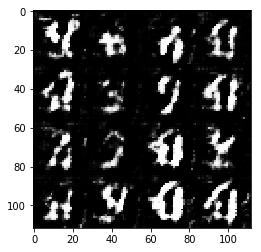

Epoch 0/2... Discriminator Loss: 1.2459... Generator Loss: 1.9052
Epoch 0/2... Discriminator Loss: 1.0410... Generator Loss: 1.0110
Epoch 0/2... Discriminator Loss: 1.1964... Generator Loss: 1.0800
Epoch 0/2... Discriminator Loss: 1.3984... Generator Loss: 1.4438
Epoch 0/2... Discriminator Loss: 0.8376... Generator Loss: 1.3419
Epoch 0/2... Discriminator Loss: 1.3699... Generator Loss: 0.8198
Epoch 0/2... Discriminator Loss: 1.2915... Generator Loss: 1.1898
Epoch 0/2... Discriminator Loss: 1.2990... Generator Loss: 0.9038
Epoch 0/2... Discriminator Loss: 1.6503... Generator Loss: 0.7404
Epoch 0/2... Discriminator Loss: 1.6945... Generator Loss: 0.7237
Epoch 0/2... Discriminator Loss: 1.6323... Generator Loss: 1.3623
Epoch 0/2... Discriminator Loss: 1.2420... Generator Loss: 0.7604
Epoch 0/2... Discriminator Loss: 1.5228... Generator Loss: 0.7429
Epoch 0/2... Discriminator Loss: 1.2708... Generator Loss: 1.2453
Epoch 0/2... Discriminator Loss: 1.5880... Generator Loss: 1.3522
Epoch 0/2.

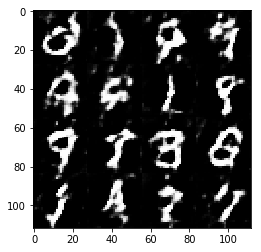

Epoch 0/2... Discriminator Loss: 1.1335... Generator Loss: 1.4515
Epoch 0/2... Discriminator Loss: 1.5141... Generator Loss: 0.7207
Epoch 0/2... Discriminator Loss: 1.0788... Generator Loss: 0.9726
Epoch 0/2... Discriminator Loss: 1.6440... Generator Loss: 2.3382
Epoch 0/2... Discriminator Loss: 1.3245... Generator Loss: 0.6877
Epoch 0/2... Discriminator Loss: 1.2887... Generator Loss: 0.5678
Epoch 0/2... Discriminator Loss: 1.1330... Generator Loss: 1.8170
Epoch 0/2... Discriminator Loss: 1.0901... Generator Loss: 1.1059
Epoch 0/2... Discriminator Loss: 1.5303... Generator Loss: 0.6677
Epoch 0/2... Discriminator Loss: 1.0185... Generator Loss: 1.3591
Epoch 0/2... Discriminator Loss: 1.2070... Generator Loss: 1.3539
Epoch 0/2... Discriminator Loss: 1.0752... Generator Loss: 1.2578
Epoch 0/2... Discriminator Loss: 1.5664... Generator Loss: 0.8262
Epoch 0/2... Discriminator Loss: 1.5103... Generator Loss: 0.8439
Epoch 0/2... Discriminator Loss: 1.3126... Generator Loss: 0.8784
Epoch 0/2.

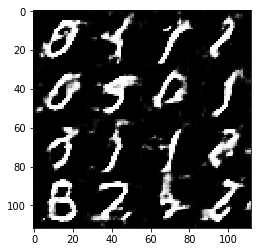

Epoch 0/2... Discriminator Loss: 1.3490... Generator Loss: 1.6940
Epoch 0/2... Discriminator Loss: 1.1485... Generator Loss: 1.2062
Epoch 0/2... Discriminator Loss: 1.2119... Generator Loss: 0.7538
Epoch 0/2... Discriminator Loss: 1.2457... Generator Loss: 1.6499
Epoch 0/2... Discriminator Loss: 1.4071... Generator Loss: 1.4985
Epoch 0/2... Discriminator Loss: 1.3685... Generator Loss: 0.5434
Epoch 0/2... Discriminator Loss: 1.0568... Generator Loss: 1.5257
Epoch 0/2... Discriminator Loss: 1.3710... Generator Loss: 0.9345
Epoch 0/2... Discriminator Loss: 1.9361... Generator Loss: 0.8402
Epoch 0/2... Discriminator Loss: 1.2061... Generator Loss: 1.0381
Epoch 0/2... Discriminator Loss: 1.3907... Generator Loss: 0.9058
Epoch 0/2... Discriminator Loss: 1.0996... Generator Loss: 0.7924
Epoch 0/2... Discriminator Loss: 1.2246... Generator Loss: 0.8639
Epoch 0/2... Discriminator Loss: 1.2907... Generator Loss: 0.9745
Epoch 0/2... Discriminator Loss: 1.4880... Generator Loss: 0.7409
Epoch 0/2.

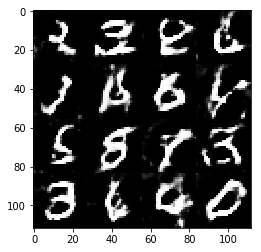

Epoch 0/2... Discriminator Loss: 1.1458... Generator Loss: 0.7555
Epoch 0/2... Discriminator Loss: 1.3195... Generator Loss: 0.7279
Epoch 0/2... Discriminator Loss: 1.3745... Generator Loss: 0.8522
Epoch 0/2... Discriminator Loss: 1.2220... Generator Loss: 1.4919
Epoch 0/2... Discriminator Loss: 1.1759... Generator Loss: 1.0785
Epoch 0/2... Discriminator Loss: 1.1025... Generator Loss: 0.6385
Epoch 0/2... Discriminator Loss: 1.3163... Generator Loss: 0.7613
Epoch 0/2... Discriminator Loss: 1.8282... Generator Loss: 0.5084
Epoch 0/2... Discriminator Loss: 1.1573... Generator Loss: 1.0419
Epoch 0/2... Discriminator Loss: 1.4870... Generator Loss: 0.7518
Epoch 0/2... Discriminator Loss: 1.2181... Generator Loss: 1.3560
Epoch 0/2... Discriminator Loss: 1.1006... Generator Loss: 1.1909
Epoch 0/2... Discriminator Loss: 1.4122... Generator Loss: 0.9424
Epoch 0/2... Discriminator Loss: 1.2632... Generator Loss: 1.0673
Epoch 0/2... Discriminator Loss: 0.9857... Generator Loss: 1.5824
Epoch 0/2.

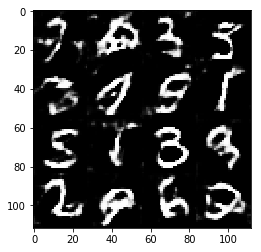

Epoch 0/2... Discriminator Loss: 1.2911... Generator Loss: 0.7298
Epoch 0/2... Discriminator Loss: 1.3047... Generator Loss: 0.9770
Epoch 0/2... Discriminator Loss: 1.1424... Generator Loss: 0.5977
Epoch 0/2... Discriminator Loss: 1.1782... Generator Loss: 1.0918
Epoch 0/2... Discriminator Loss: 1.1474... Generator Loss: 0.9250
Epoch 0/2... Discriminator Loss: 1.1126... Generator Loss: 1.3600
Epoch 0/2... Discriminator Loss: 1.1372... Generator Loss: 1.0821
Epoch 0/2... Discriminator Loss: 1.1692... Generator Loss: 1.1893
Epoch 0/2... Discriminator Loss: 1.5358... Generator Loss: 0.6465
Epoch 0/2... Discriminator Loss: 1.0623... Generator Loss: 1.3045
Epoch 0/2... Discriminator Loss: 1.1507... Generator Loss: 1.2794
Epoch 0/2... Discriminator Loss: 1.0139... Generator Loss: 1.8130
Epoch 0/2... Discriminator Loss: 1.3579... Generator Loss: 0.7458
Epoch 0/2... Discriminator Loss: 1.4199... Generator Loss: 0.8882
Epoch 0/2... Discriminator Loss: 1.1679... Generator Loss: 1.1966
Epoch 0/2.

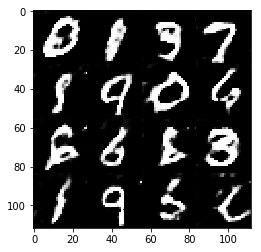

Epoch 0/2... Discriminator Loss: 1.2841... Generator Loss: 2.6820
Epoch 0/2... Discriminator Loss: 1.3832... Generator Loss: 0.9379
Epoch 0/2... Discriminator Loss: 0.8962... Generator Loss: 1.0177
Epoch 0/2... Discriminator Loss: 0.9128... Generator Loss: 1.0877
Epoch 0/2... Discriminator Loss: 1.1113... Generator Loss: 1.6903
Epoch 0/2... Discriminator Loss: 1.0624... Generator Loss: 2.2481
Epoch 0/2... Discriminator Loss: 1.5583... Generator Loss: 0.8727
Epoch 0/2... Discriminator Loss: 1.1783... Generator Loss: 0.8238
Epoch 0/2... Discriminator Loss: 1.3587... Generator Loss: 0.9934
Epoch 0/2... Discriminator Loss: 1.4121... Generator Loss: 0.6941
Epoch 0/2... Discriminator Loss: 1.0315... Generator Loss: 1.0722
Epoch 0/2... Discriminator Loss: 1.0991... Generator Loss: 0.9582
Epoch 0/2... Discriminator Loss: 0.8959... Generator Loss: 0.9038
Epoch 0/2... Discriminator Loss: 1.3062... Generator Loss: 0.8043
Epoch 0/2... Discriminator Loss: 1.1434... Generator Loss: 1.1705
Epoch 0/2.

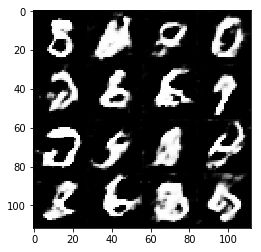

Epoch 0/2... Discriminator Loss: 0.8422... Generator Loss: 1.4750
Epoch 0/2... Discriminator Loss: 1.3555... Generator Loss: 1.7309
Epoch 0/2... Discriminator Loss: 1.4709... Generator Loss: 1.8955
Epoch 0/2... Discriminator Loss: 1.5552... Generator Loss: 0.5711
Epoch 0/2... Discriminator Loss: 0.9995... Generator Loss: 1.3700
Epoch 0/2... Discriminator Loss: 1.0545... Generator Loss: 1.3861
Epoch 0/2... Discriminator Loss: 1.3546... Generator Loss: 0.9990
Epoch 0/2... Discriminator Loss: 0.8429... Generator Loss: 1.1033
Epoch 0/2... Discriminator Loss: 1.1426... Generator Loss: 0.9890
Epoch 0/2... Discriminator Loss: 1.4573... Generator Loss: 0.8357
Epoch 0/2... Discriminator Loss: 1.2962... Generator Loss: 0.8673
Epoch 0/2... Discriminator Loss: 1.0354... Generator Loss: 1.4638
Epoch 0/2... Discriminator Loss: 1.2084... Generator Loss: 0.8236
Epoch 0/2... Discriminator Loss: 0.9546... Generator Loss: 0.6335
Epoch 0/2... Discriminator Loss: 1.2481... Generator Loss: 0.8401
Epoch 0/2.

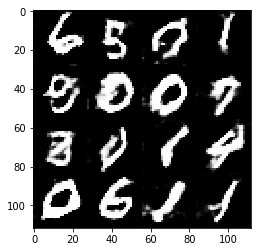

Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.8540
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.5941
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 1.4002
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.6446
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.8285
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 2.1493
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 1.9869
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 2.4049
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 1.1156
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.1073
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.8503
Epoch 1/2.

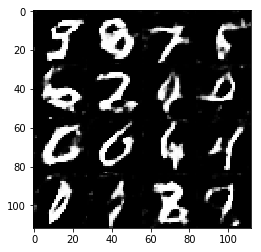

Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.1640
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 1.8985
Epoch 1/2... Discriminator Loss: 0.9093... Generator Loss: 1.3191
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 3.0848
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.7211
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.6581
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.5733
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 2.5235
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 1.7694
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.6007
Epoch 1/2.

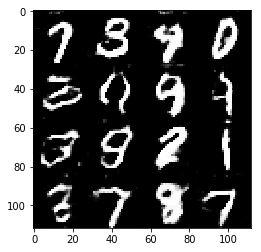

Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.3295
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.5253
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 2.3710
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 1.4173
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 2.1841
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.7496
Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.7911
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 2.0749
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.4583
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.5257
Epoch 1/2.

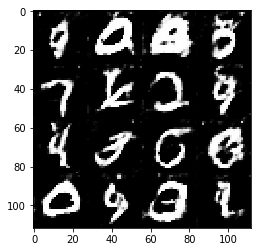

Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 1.7068... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.9256
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.6885
Epoch 1/2... Discriminator Loss: 1.6721... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 2.4157
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 2.0497
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.0811
Epoch 1/2.

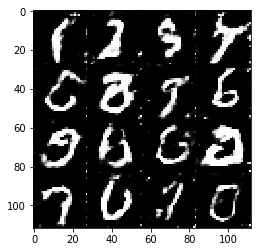

Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.4720
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 2.5498
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.6858
Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 1.7352
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 2.1559
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 1.7342
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.9915
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.9639
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 2.9564
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 2.1760
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 2.4620
Epoch 1/2... Discriminator Loss: 0.7202... Generator Loss: 2.1650
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 2.1275
Epoch 1/2.

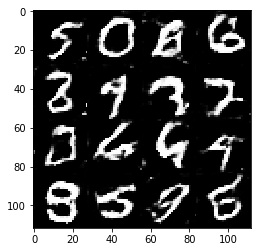

Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 2.5283
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 2.6525
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 1.7916
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 3.6543
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 1.8193
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 1.2160
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.3784
Epoch 1/2... Discriminator Loss: 1.5646... Generator Loss: 0.7930
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 2.6784
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 2.0500
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 0.7858
Epoch 1/2.

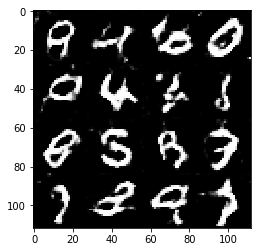

Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 1.7770
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 3.3780
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 2.0186
Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 2.2131
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.9696
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 2.4590
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 1.2117
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 2.7652
Epoch 1/2... Discriminator Loss: 0.8958... Generator Loss: 2.9277
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 2.7372
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 2.9177
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.7280
Epoch 1/2.

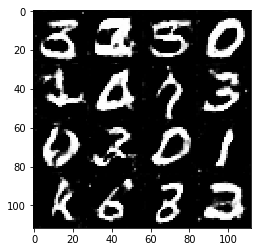

In [12]:
%timeit

batch_size = 16
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.2167... Generator Loss: 1.7126
Epoch 0/1... Discriminator Loss: 1.5043... Generator Loss: 0.9691
Epoch 0/1... Discriminator Loss: 1.1798... Generator Loss: 0.9964
Epoch 0/1... Discriminator Loss: 1.3226... Generator Loss: 1.8747
Epoch 0/1... Discriminator Loss: 1.0959... Generator Loss: 3.3626
Epoch 0/1... Discriminator Loss: 1.4527... Generator Loss: 0.9057
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 4.1487
Epoch 0/1... Discriminator Loss: 0.9932... Generator Loss: 1.9956
Epoch 0/1... Discriminator Loss: 0.8958... Generator Loss: 1.3526
Epoch 0/1... Discriminator Loss: 1.3447... Generator Loss: 1.8928
Epoch 0/1... Discriminator Loss: 0.6363... Generator Loss: 2.6048
Epoch 0/1... Discriminator Loss: 0.8038... Generator Loss: 2.0137
Epoch 0/1... Discriminator Loss: 0.6465... Generator Loss: 1.6449
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 3.4128
Epoch 0/1... Discriminator Loss: 0.8832... Generator Loss: 4.4226
Epoch 0/1.

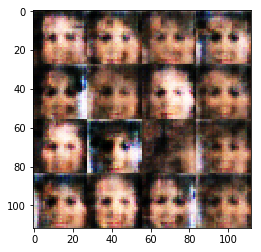

Epoch 0/1... Discriminator Loss: 1.0996... Generator Loss: 0.9555
Epoch 0/1... Discriminator Loss: 1.5007... Generator Loss: 0.9008
Epoch 0/1... Discriminator Loss: 1.8331... Generator Loss: 1.1114
Epoch 0/1... Discriminator Loss: 1.3936... Generator Loss: 0.7944
Epoch 0/1... Discriminator Loss: 2.3243... Generator Loss: 0.4630
Epoch 0/1... Discriminator Loss: 1.1625... Generator Loss: 1.0732
Epoch 0/1... Discriminator Loss: 1.3887... Generator Loss: 1.0254
Epoch 0/1... Discriminator Loss: 1.7116... Generator Loss: 0.5673
Epoch 0/1... Discriminator Loss: 1.6701... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.5540... Generator Loss: 1.0903
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 1.0228
Epoch 0/1... Discriminator Loss: 1.6688... Generator Loss: 0.9840
Epoch 0/1... Discriminator Loss: 1.4323... Generator Loss: 1.1030
Epoch 0/1... Discriminator Loss: 1.1856... Generator Loss: 0.9266
Epoch 0/1... Discriminator Loss: 1.3880... Generator Loss: 0.6899
Epoch 0/1.

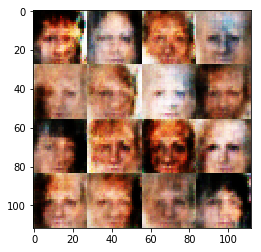

Epoch 0/1... Discriminator Loss: 1.2343... Generator Loss: 1.1457
Epoch 0/1... Discriminator Loss: 1.5922... Generator Loss: 0.9593
Epoch 0/1... Discriminator Loss: 1.4798... Generator Loss: 0.7897
Epoch 0/1... Discriminator Loss: 1.3287... Generator Loss: 0.9073
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.8248
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 1.2786
Epoch 0/1... Discriminator Loss: 1.2914... Generator Loss: 0.6770
Epoch 0/1... Discriminator Loss: 1.2703... Generator Loss: 0.9546
Epoch 0/1... Discriminator Loss: 1.2620... Generator Loss: 0.8653
Epoch 0/1... Discriminator Loss: 1.3634... Generator Loss: 0.8003
Epoch 0/1... Discriminator Loss: 1.2726... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 1.5568... Generator Loss: 0.5243
Epoch 0/1... Discriminator Loss: 1.2078... Generator Loss: 0.8218
Epoch 0/1... Discriminator Loss: 1.5333... Generator Loss: 0.6031
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 1.0864
Epoch 0/1.

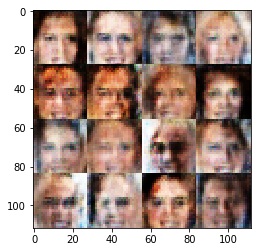

Epoch 0/1... Discriminator Loss: 1.3144... Generator Loss: 0.9078
Epoch 0/1... Discriminator Loss: 1.4385... Generator Loss: 0.7701
Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.7076
Epoch 0/1... Discriminator Loss: 1.4086... Generator Loss: 0.9643
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 1.1417
Epoch 0/1... Discriminator Loss: 1.3080... Generator Loss: 1.0920
Epoch 0/1... Discriminator Loss: 1.3547... Generator Loss: 0.8552
Epoch 0/1... Discriminator Loss: 1.3257... Generator Loss: 0.8773
Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.9694
Epoch 0/1... Discriminator Loss: 1.3798... Generator Loss: 0.7944
Epoch 0/1... Discriminator Loss: 1.5545... Generator Loss: 0.9435
Epoch 0/1... Discriminator Loss: 1.6094... Generator Loss: 0.9195
Epoch 0/1... Discriminator Loss: 1.3929... Generator Loss: 0.6496
Epoch 0/1... Discriminator Loss: 1.4431... Generator Loss: 0.8336
Epoch 0/1... Discriminator Loss: 1.4917... Generator Loss: 0.5999
Epoch 0/1.

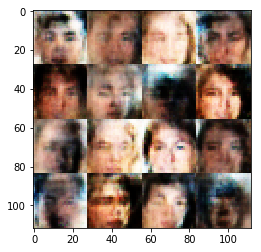

Epoch 0/1... Discriminator Loss: 1.4269... Generator Loss: 0.8926
Epoch 0/1... Discriminator Loss: 1.3067... Generator Loss: 0.9098
Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 1.2903... Generator Loss: 0.8544
Epoch 0/1... Discriminator Loss: 1.4787... Generator Loss: 0.7178
Epoch 0/1... Discriminator Loss: 1.4671... Generator Loss: 0.7291
Epoch 0/1... Discriminator Loss: 1.4117... Generator Loss: 0.7700
Epoch 0/1... Discriminator Loss: 1.4302... Generator Loss: 0.9577
Epoch 0/1... Discriminator Loss: 1.6438... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.2974... Generator Loss: 0.8305
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 0.9455
Epoch 0/1... Discriminator Loss: 1.2707... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 1.5124... Generator Loss: 0.7794
Epoch 0/1... Discriminator Loss: 1.4734... Generator Loss: 0.8983
Epoch 0/1... Discriminator Loss: 1.3380... Generator Loss: 0.7229
Epoch 0/1.

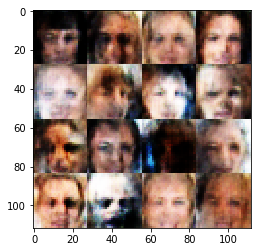

Epoch 0/1... Discriminator Loss: 1.3839... Generator Loss: 0.8283
Epoch 0/1... Discriminator Loss: 1.4064... Generator Loss: 0.9976
Epoch 0/1... Discriminator Loss: 1.4209... Generator Loss: 0.9940
Epoch 0/1... Discriminator Loss: 1.3113... Generator Loss: 0.6951
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.7733
Epoch 0/1... Discriminator Loss: 1.5519... Generator Loss: 0.7047
Epoch 0/1... Discriminator Loss: 1.3737... Generator Loss: 0.7727
Epoch 0/1... Discriminator Loss: 1.3864... Generator Loss: 0.8238
Epoch 0/1... Discriminator Loss: 1.3338... Generator Loss: 0.7791
Epoch 0/1... Discriminator Loss: 1.3654... Generator Loss: 0.8871
Epoch 0/1... Discriminator Loss: 1.4642... Generator Loss: 0.5708
Epoch 0/1... Discriminator Loss: 1.3553... Generator Loss: 1.0173
Epoch 0/1... Discriminator Loss: 1.3035... Generator Loss: 0.7102
Epoch 0/1... Discriminator Loss: 1.3914... Generator Loss: 0.7925
Epoch 0/1... Discriminator Loss: 1.2758... Generator Loss: 0.7342
Epoch 0/1.

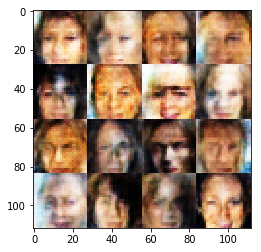

Epoch 0/1... Discriminator Loss: 1.2057... Generator Loss: 0.7964
Epoch 0/1... Discriminator Loss: 1.3160... Generator Loss: 0.9011
Epoch 0/1... Discriminator Loss: 1.3687... Generator Loss: 0.7070
Epoch 0/1... Discriminator Loss: 1.5448... Generator Loss: 0.8525
Epoch 0/1... Discriminator Loss: 1.2108... Generator Loss: 0.8556
Epoch 0/1... Discriminator Loss: 1.4816... Generator Loss: 0.9459
Epoch 0/1... Discriminator Loss: 1.2503... Generator Loss: 1.0745
Epoch 0/1... Discriminator Loss: 1.1598... Generator Loss: 1.0235
Epoch 0/1... Discriminator Loss: 1.4771... Generator Loss: 0.7395
Epoch 0/1... Discriminator Loss: 1.4650... Generator Loss: 0.8862
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.7620
Epoch 0/1... Discriminator Loss: 1.1791... Generator Loss: 0.8877
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.8696
Epoch 0/1... Discriminator Loss: 1.4033... Generator Loss: 0.8227
Epoch 0/1... Discriminator Loss: 1.5209... Generator Loss: 1.0215
Epoch 0/1.

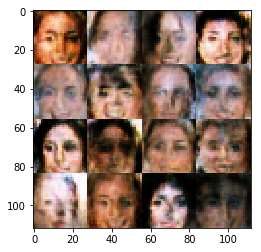

Epoch 0/1... Discriminator Loss: 1.2511... Generator Loss: 0.9695
Epoch 0/1... Discriminator Loss: 1.4997... Generator Loss: 0.7628
Epoch 0/1... Discriminator Loss: 1.2808... Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 1.4137... Generator Loss: 0.9456
Epoch 0/1... Discriminator Loss: 1.3447... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 1.3086... Generator Loss: 0.9067
Epoch 0/1... Discriminator Loss: 1.3301... Generator Loss: 0.8340
Epoch 0/1... Discriminator Loss: 1.3607... Generator Loss: 0.7411
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 0.7943
Epoch 0/1... Discriminator Loss: 1.2444... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 1.2724... Generator Loss: 0.6821
Epoch 0/1... Discriminator Loss: 1.3580... Generator Loss: 0.7141
Epoch 0/1... Discriminator Loss: 1.4539... Generator Loss: 0.8363
Epoch 0/1... Discriminator Loss: 1.3041... Generator Loss: 0.6745
Epoch 0/1... Discriminator Loss: 1.2932... Generator Loss: 0.7664
Epoch 0/1.

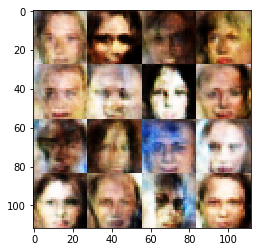

Epoch 0/1... Discriminator Loss: 1.3675... Generator Loss: 0.8947
Epoch 0/1... Discriminator Loss: 1.4015... Generator Loss: 0.7149
Epoch 0/1... Discriminator Loss: 1.2378... Generator Loss: 0.9159
Epoch 0/1... Discriminator Loss: 1.3463... Generator Loss: 1.0964
Epoch 0/1... Discriminator Loss: 1.2536... Generator Loss: 0.7938
Epoch 0/1... Discriminator Loss: 1.2976... Generator Loss: 0.9843
Epoch 0/1... Discriminator Loss: 1.3415... Generator Loss: 0.8423
Epoch 0/1... Discriminator Loss: 1.2938... Generator Loss: 0.9082
Epoch 0/1... Discriminator Loss: 1.2222... Generator Loss: 0.7931
Epoch 0/1... Discriminator Loss: 1.4470... Generator Loss: 0.8943
Epoch 0/1... Discriminator Loss: 1.3662... Generator Loss: 1.0559
Epoch 0/1... Discriminator Loss: 1.3592... Generator Loss: 0.7145
Epoch 0/1... Discriminator Loss: 1.4414... Generator Loss: 0.6810
Epoch 0/1... Discriminator Loss: 1.3407... Generator Loss: 0.9049
Epoch 0/1... Discriminator Loss: 1.1763... Generator Loss: 0.9142
Epoch 0/1.

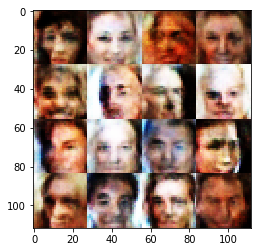

Epoch 0/1... Discriminator Loss: 1.1643... Generator Loss: 0.6393
Epoch 0/1... Discriminator Loss: 1.4301... Generator Loss: 0.7116
Epoch 0/1... Discriminator Loss: 1.4030... Generator Loss: 0.8742
Epoch 0/1... Discriminator Loss: 1.4527... Generator Loss: 1.2094
Epoch 0/1... Discriminator Loss: 1.4035... Generator Loss: 1.0903
Epoch 0/1... Discriminator Loss: 1.4087... Generator Loss: 0.8084
Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 0.7607
Epoch 0/1... Discriminator Loss: 1.3038... Generator Loss: 0.6489
Epoch 0/1... Discriminator Loss: 1.2135... Generator Loss: 0.9830
Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 1.3856... Generator Loss: 1.0063
Epoch 0/1... Discriminator Loss: 1.3304... Generator Loss: 0.9305
Epoch 0/1... Discriminator Loss: 1.4324... Generator Loss: 0.7717
Epoch 0/1... Discriminator Loss: 1.4031... Generator Loss: 0.7655
Epoch 0/1... Discriminator Loss: 1.3009... Generator Loss: 0.9103
Epoch 0/1.

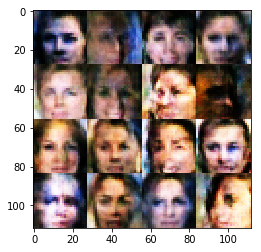

Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.8418
Epoch 0/1... Discriminator Loss: 1.3013... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.1772... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 1.2862... Generator Loss: 0.8683
Epoch 0/1... Discriminator Loss: 1.3727... Generator Loss: 0.9892
Epoch 0/1... Discriminator Loss: 1.4678... Generator Loss: 1.0735
Epoch 0/1... Discriminator Loss: 1.0855... Generator Loss: 0.8312
Epoch 0/1... Discriminator Loss: 1.3171... Generator Loss: 0.8520
Epoch 0/1... Discriminator Loss: 1.6230... Generator Loss: 0.6554
Epoch 0/1... Discriminator Loss: 1.2330... Generator Loss: 0.7498
Epoch 0/1... Discriminator Loss: 1.2502... Generator Loss: 0.9085
Epoch 0/1... Discriminator Loss: 1.3200... Generator Loss: 1.0121
Epoch 0/1... Discriminator Loss: 1.3338... Generator Loss: 0.9107
Epoch 0/1... Discriminator Loss: 1.1727... Generator Loss: 1.0903
Epoch 0/1... Discriminator Loss: 1.4391... Generator Loss: 0.7279
Epoch 0/1.

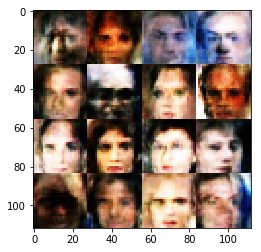

Epoch 0/1... Discriminator Loss: 1.1084... Generator Loss: 0.8529
Epoch 0/1... Discriminator Loss: 1.2144... Generator Loss: 0.8245
Epoch 0/1... Discriminator Loss: 1.3171... Generator Loss: 0.9086
Epoch 0/1... Discriminator Loss: 1.3520... Generator Loss: 1.0029
Epoch 0/1... Discriminator Loss: 1.4102... Generator Loss: 0.9244
Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.8541
Epoch 0/1... Discriminator Loss: 1.3066... Generator Loss: 0.9275
Epoch 0/1... Discriminator Loss: 1.3443... Generator Loss: 0.7371
Epoch 0/1... Discriminator Loss: 1.0922... Generator Loss: 0.9716
Epoch 0/1... Discriminator Loss: 1.4105... Generator Loss: 0.7221
Epoch 0/1... Discriminator Loss: 1.5680... Generator Loss: 0.6045
Epoch 0/1... Discriminator Loss: 1.4233... Generator Loss: 1.0677
Epoch 0/1... Discriminator Loss: 1.4095... Generator Loss: 0.8142
Epoch 0/1... Discriminator Loss: 1.2109... Generator Loss: 0.8698
Epoch 0/1... Discriminator Loss: 1.6206... Generator Loss: 0.7430
Epoch 0/1.

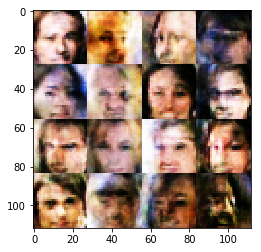

Epoch 0/1... Discriminator Loss: 1.3418... Generator Loss: 0.8606
Epoch 0/1... Discriminator Loss: 1.3099... Generator Loss: 0.7825
Epoch 0/1... Discriminator Loss: 1.1789... Generator Loss: 0.6178
Epoch 0/1... Discriminator Loss: 1.3180... Generator Loss: 0.9421
Epoch 0/1... Discriminator Loss: 1.4168... Generator Loss: 0.8723
Epoch 0/1... Discriminator Loss: 1.3786... Generator Loss: 0.8247
Epoch 0/1... Discriminator Loss: 1.2826... Generator Loss: 0.9708
Epoch 0/1... Discriminator Loss: 1.2695... Generator Loss: 1.0984
Epoch 0/1... Discriminator Loss: 1.2502... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.2540... Generator Loss: 0.9234
Epoch 0/1... Discriminator Loss: 1.2628... Generator Loss: 0.8006
Epoch 0/1... Discriminator Loss: 1.3504... Generator Loss: 1.0903
Epoch 0/1... Discriminator Loss: 1.2285... Generator Loss: 0.8522
Epoch 0/1... Discriminator Loss: 1.2361... Generator Loss: 0.8931
Epoch 0/1... Discriminator Loss: 1.1233... Generator Loss: 1.0615
Epoch 0/1.

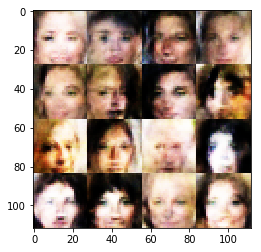

Epoch 0/1... Discriminator Loss: 1.2973... Generator Loss: 1.1246
Epoch 0/1... Discriminator Loss: 1.2721... Generator Loss: 0.8092
Epoch 0/1... Discriminator Loss: 1.2938... Generator Loss: 0.8286
Epoch 0/1... Discriminator Loss: 1.4101... Generator Loss: 1.2092
Epoch 0/1... Discriminator Loss: 1.2836... Generator Loss: 0.8529
Epoch 0/1... Discriminator Loss: 1.1984... Generator Loss: 0.9188
Epoch 0/1... Discriminator Loss: 1.4155... Generator Loss: 0.9033
Epoch 0/1... Discriminator Loss: 1.3444... Generator Loss: 0.9254
Epoch 0/1... Discriminator Loss: 1.2234... Generator Loss: 1.0245
Epoch 0/1... Discriminator Loss: 1.5774... Generator Loss: 1.0412
Epoch 0/1... Discriminator Loss: 1.2296... Generator Loss: 0.9285
Epoch 0/1... Discriminator Loss: 1.2409... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 1.3899... Generator Loss: 1.1089
Epoch 0/1... Discriminator Loss: 1.1733... Generator Loss: 0.5906
Epoch 0/1... Discriminator Loss: 1.2248... Generator Loss: 1.0441
Epoch 0/1.

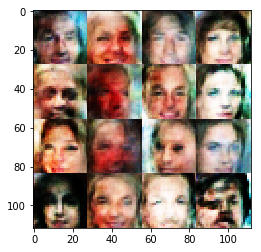

Epoch 0/1... Discriminator Loss: 1.1101... Generator Loss: 1.0200
Epoch 0/1... Discriminator Loss: 1.3560... Generator Loss: 0.9653
Epoch 0/1... Discriminator Loss: 1.2152... Generator Loss: 0.7478
Epoch 0/1... Discriminator Loss: 1.3560... Generator Loss: 1.0186
Epoch 0/1... Discriminator Loss: 1.2111... Generator Loss: 1.0741
Epoch 0/1... Discriminator Loss: 1.3350... Generator Loss: 0.9099
Epoch 0/1... Discriminator Loss: 1.2868... Generator Loss: 1.0375
Epoch 0/1... Discriminator Loss: 1.3354... Generator Loss: 0.7970
Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.9028
Epoch 0/1... Discriminator Loss: 1.2345... Generator Loss: 0.8298
Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.9034
Epoch 0/1... Discriminator Loss: 1.1533... Generator Loss: 0.5599
Epoch 0/1... Discriminator Loss: 1.3384... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.2291... Generator Loss: 1.1936
Epoch 0/1... Discriminator Loss: 1.1860... Generator Loss: 0.8865
Epoch 0/1.

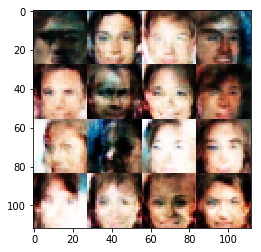

Epoch 0/1... Discriminator Loss: 1.3508... Generator Loss: 1.0020
Epoch 0/1... Discriminator Loss: 1.1176... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 1.6074... Generator Loss: 1.1878
Epoch 0/1... Discriminator Loss: 1.2161... Generator Loss: 0.9638
Epoch 0/1... Discriminator Loss: 1.3089... Generator Loss: 0.9633
Epoch 0/1... Discriminator Loss: 1.1820... Generator Loss: 1.3370
Epoch 0/1... Discriminator Loss: 1.2871... Generator Loss: 0.8804
Epoch 0/1... Discriminator Loss: 1.2584... Generator Loss: 1.0803
Epoch 0/1... Discriminator Loss: 1.3534... Generator Loss: 1.0768
Epoch 0/1... Discriminator Loss: 1.1724... Generator Loss: 0.9106
Epoch 0/1... Discriminator Loss: 1.2112... Generator Loss: 0.7632
Epoch 0/1... Discriminator Loss: 1.2016... Generator Loss: 0.9580
Epoch 0/1... Discriminator Loss: 1.3366... Generator Loss: 1.2468
Epoch 0/1... Discriminator Loss: 1.2116... Generator Loss: 1.2105
Epoch 0/1... Discriminator Loss: 1.1525... Generator Loss: 0.9001
Epoch 0/1.

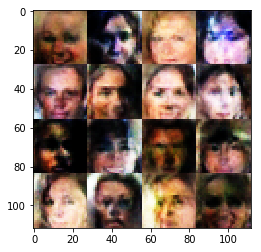

Epoch 0/1... Discriminator Loss: 1.2288... Generator Loss: 1.2687
Epoch 0/1... Discriminator Loss: 1.3630... Generator Loss: 0.8384
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.1842
Epoch 0/1... Discriminator Loss: 1.1124... Generator Loss: 1.1440
Epoch 0/1... Discriminator Loss: 1.0407... Generator Loss: 0.9755
Epoch 0/1... Discriminator Loss: 1.2101... Generator Loss: 0.8062
Epoch 0/1... Discriminator Loss: 1.3644... Generator Loss: 1.1428
Epoch 0/1... Discriminator Loss: 1.2930... Generator Loss: 0.7757
Epoch 0/1... Discriminator Loss: 1.2982... Generator Loss: 1.0337
Epoch 0/1... Discriminator Loss: 1.3265... Generator Loss: 0.8907
Epoch 0/1... Discriminator Loss: 1.2228... Generator Loss: 0.7153
Epoch 0/1... Discriminator Loss: 1.4200... Generator Loss: 0.7910
Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.2106... Generator Loss: 1.0875
Epoch 0/1... Discriminator Loss: 1.2256... Generator Loss: 0.8236
Epoch 0/1.

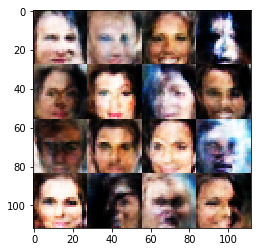

Epoch 0/1... Discriminator Loss: 1.2256... Generator Loss: 1.2327
Epoch 0/1... Discriminator Loss: 1.0051... Generator Loss: 1.0519
Epoch 0/1... Discriminator Loss: 1.3455... Generator Loss: 1.2499
Epoch 0/1... Discriminator Loss: 1.1335... Generator Loss: 1.1889
Epoch 0/1... Discriminator Loss: 1.3670... Generator Loss: 0.9550
Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.9777
Epoch 0/1... Discriminator Loss: 1.4320... Generator Loss: 1.0699
Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 1.3674
Epoch 0/1... Discriminator Loss: 1.2143... Generator Loss: 0.8549
Epoch 0/1... Discriminator Loss: 1.1073... Generator Loss: 1.0387
Epoch 0/1... Discriminator Loss: 1.1795... Generator Loss: 1.3359
Epoch 0/1... Discriminator Loss: 1.1247... Generator Loss: 1.0948
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 0.8492
Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.8709
Epoch 0/1... Discriminator Loss: 1.1995... Generator Loss: 0.8245
Epoch 0/1.

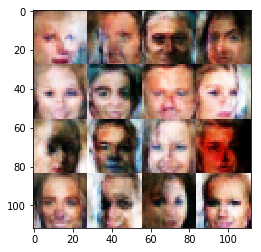

Epoch 0/1... Discriminator Loss: 1.3064... Generator Loss: 1.2423
Epoch 0/1... Discriminator Loss: 1.1183... Generator Loss: 1.1511
Epoch 0/1... Discriminator Loss: 1.2344... Generator Loss: 1.1167
Epoch 0/1... Discriminator Loss: 1.4445... Generator Loss: 1.0556
Epoch 0/1... Discriminator Loss: 0.9832... Generator Loss: 1.1796
Epoch 0/1... Discriminator Loss: 1.1535... Generator Loss: 0.8818
Epoch 0/1... Discriminator Loss: 1.2461... Generator Loss: 1.1446
Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 0.7946
Epoch 0/1... Discriminator Loss: 1.1476... Generator Loss: 0.9988
Epoch 0/1... Discriminator Loss: 1.1329... Generator Loss: 0.8938
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 0.7283
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 1.0851
Epoch 0/1... Discriminator Loss: 1.1418... Generator Loss: 0.9348
Epoch 0/1... Discriminator Loss: 1.0206... Generator Loss: 0.8369
Epoch 0/1... Discriminator Loss: 1.0727... Generator Loss: 1.2559
Epoch 0/1.

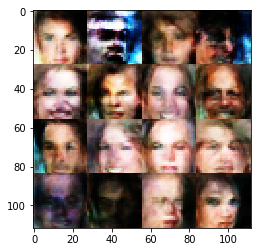

Epoch 0/1... Discriminator Loss: 1.2459... Generator Loss: 0.8918
Epoch 0/1... Discriminator Loss: 1.1554... Generator Loss: 0.8155
Epoch 0/1... Discriminator Loss: 1.3821... Generator Loss: 1.0925
Epoch 0/1... Discriminator Loss: 1.2372... Generator Loss: 0.8708
Epoch 0/1... Discriminator Loss: 1.0911... Generator Loss: 1.0311
Epoch 0/1... Discriminator Loss: 1.3937... Generator Loss: 0.9635
Epoch 0/1... Discriminator Loss: 1.0734... Generator Loss: 0.9101
Epoch 0/1... Discriminator Loss: 1.1894... Generator Loss: 0.6292
Epoch 0/1... Discriminator Loss: 1.2999... Generator Loss: 0.7574
Epoch 0/1... Discriminator Loss: 1.0730... Generator Loss: 1.1818
Epoch 0/1... Discriminator Loss: 1.4164... Generator Loss: 1.1495
Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 1.3214
Epoch 0/1... Discriminator Loss: 1.1632... Generator Loss: 1.2953
Epoch 0/1... Discriminator Loss: 1.1600... Generator Loss: 1.3488
Epoch 0/1... Discriminator Loss: 1.1552... Generator Loss: 0.9460
Epoch 0/1.

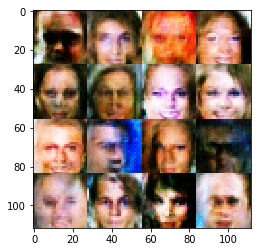

Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.6913
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 0.8691
Epoch 0/1... Discriminator Loss: 1.2183... Generator Loss: 1.2085
Epoch 0/1... Discriminator Loss: 1.4417... Generator Loss: 0.9282
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 1.1615
Epoch 0/1... Discriminator Loss: 1.3893... Generator Loss: 1.2859
Epoch 0/1... Discriminator Loss: 1.1316... Generator Loss: 1.2341
Epoch 0/1... Discriminator Loss: 1.2798... Generator Loss: 0.7920
Epoch 0/1... Discriminator Loss: 1.1495... Generator Loss: 1.2889
Epoch 0/1... Discriminator Loss: 1.2434... Generator Loss: 0.9932
Epoch 0/1... Discriminator Loss: 1.2281... Generator Loss: 0.8410
Epoch 0/1... Discriminator Loss: 1.1677... Generator Loss: 1.2343
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.1472
Epoch 0/1... Discriminator Loss: 0.9678... Generator Loss: 1.0511
Epoch 0/1... Discriminator Loss: 1.1251... Generator Loss: 0.8078
Epoch 0/1.

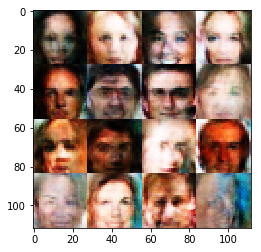

Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.8736
Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.9949
Epoch 0/1... Discriminator Loss: 1.1993... Generator Loss: 0.9688
Epoch 0/1... Discriminator Loss: 1.0658... Generator Loss: 1.1934
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 0.8607
Epoch 0/1... Discriminator Loss: 1.1313... Generator Loss: 1.0609
Epoch 0/1... Discriminator Loss: 1.0768... Generator Loss: 1.4769
Epoch 0/1... Discriminator Loss: 1.3884... Generator Loss: 0.9335
Epoch 0/1... Discriminator Loss: 1.3571... Generator Loss: 0.9914
Epoch 0/1... Discriminator Loss: 1.2755... Generator Loss: 1.0463
Epoch 0/1... Discriminator Loss: 1.3644... Generator Loss: 1.6006
Epoch 0/1... Discriminator Loss: 1.5312... Generator Loss: 1.2778
Epoch 0/1... Discriminator Loss: 1.2254... Generator Loss: 0.7950
Epoch 0/1... Discriminator Loss: 1.4603... Generator Loss: 0.8518
Epoch 0/1... Discriminator Loss: 1.1501... Generator Loss: 0.8911
Epoch 0/1.

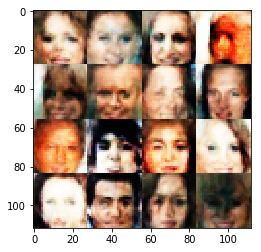

Epoch 0/1... Discriminator Loss: 1.4486... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.1054... Generator Loss: 1.2051
Epoch 0/1... Discriminator Loss: 1.0488... Generator Loss: 1.3913
Epoch 0/1... Discriminator Loss: 1.3584... Generator Loss: 1.0332
Epoch 0/1... Discriminator Loss: 1.0653... Generator Loss: 1.1284
Epoch 0/1... Discriminator Loss: 1.1037... Generator Loss: 1.1369
Epoch 0/1... Discriminator Loss: 1.3314... Generator Loss: 0.8518
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.9449
Epoch 0/1... Discriminator Loss: 0.8978... Generator Loss: 1.1062
Epoch 0/1... Discriminator Loss: 1.1069... Generator Loss: 1.5057
Epoch 0/1... Discriminator Loss: 1.2442... Generator Loss: 1.1186
Epoch 0/1... Discriminator Loss: 1.2280... Generator Loss: 0.8411
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 1.1839
Epoch 0/1... Discriminator Loss: 1.2815... Generator Loss: 1.2542
Epoch 0/1... Discriminator Loss: 1.1420... Generator Loss: 1.2132
Epoch 0/1.

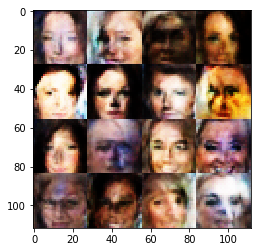

Epoch 0/1... Discriminator Loss: 1.6319... Generator Loss: 0.6090
Epoch 0/1... Discriminator Loss: 1.2509... Generator Loss: 1.2046
Epoch 0/1... Discriminator Loss: 1.1324... Generator Loss: 1.3283
Epoch 0/1... Discriminator Loss: 0.9783... Generator Loss: 1.2154
Epoch 0/1... Discriminator Loss: 1.2530... Generator Loss: 1.2668
Epoch 0/1... Discriminator Loss: 1.3295... Generator Loss: 0.9502
Epoch 0/1... Discriminator Loss: 1.2139... Generator Loss: 0.9007
Epoch 0/1... Discriminator Loss: 1.3505... Generator Loss: 1.1898
Epoch 0/1... Discriminator Loss: 0.9582... Generator Loss: 1.1112
Epoch 0/1... Discriminator Loss: 1.2657... Generator Loss: 0.9078
Epoch 0/1... Discriminator Loss: 1.3395... Generator Loss: 1.0844
Epoch 0/1... Discriminator Loss: 1.4888... Generator Loss: 0.8288
Epoch 0/1... Discriminator Loss: 1.1975... Generator Loss: 1.3099
Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.9206
Epoch 0/1... Discriminator Loss: 1.0915... Generator Loss: 1.4841
Epoch 0/1.

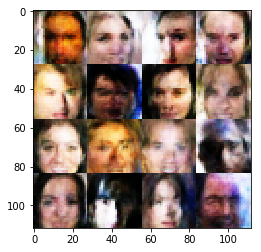

Epoch 0/1... Discriminator Loss: 1.1977... Generator Loss: 0.9667
Epoch 0/1... Discriminator Loss: 1.5662... Generator Loss: 0.6712
Epoch 0/1... Discriminator Loss: 1.1832... Generator Loss: 1.1129
Epoch 0/1... Discriminator Loss: 1.0341... Generator Loss: 0.9348
Epoch 0/1... Discriminator Loss: 1.1299... Generator Loss: 0.6817
Epoch 0/1... Discriminator Loss: 1.1379... Generator Loss: 1.0444
Epoch 0/1... Discriminator Loss: 1.3844... Generator Loss: 1.0454
Epoch 0/1... Discriminator Loss: 0.9523... Generator Loss: 1.1729
Epoch 0/1... Discriminator Loss: 0.9881... Generator Loss: 1.1655
Epoch 0/1... Discriminator Loss: 1.1964... Generator Loss: 1.0090
Epoch 0/1... Discriminator Loss: 1.2800... Generator Loss: 1.0884
Epoch 0/1... Discriminator Loss: 1.1412... Generator Loss: 1.2574
Epoch 0/1... Discriminator Loss: 1.1285... Generator Loss: 0.9923
Epoch 0/1... Discriminator Loss: 1.2208... Generator Loss: 1.2988
Epoch 0/1... Discriminator Loss: 1.3079... Generator Loss: 0.8118
Epoch 0/1.

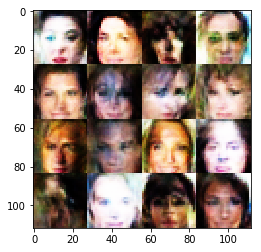

Epoch 0/1... Discriminator Loss: 1.0284... Generator Loss: 1.1224
Epoch 0/1... Discriminator Loss: 1.1307... Generator Loss: 1.1985
Epoch 0/1... Discriminator Loss: 1.2478... Generator Loss: 0.9567
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 1.1734
Epoch 0/1... Discriminator Loss: 1.0942... Generator Loss: 1.2158
Epoch 0/1... Discriminator Loss: 1.1033... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 0.9711... Generator Loss: 1.1223
Epoch 0/1... Discriminator Loss: 1.6014... Generator Loss: 0.8701
Epoch 0/1... Discriminator Loss: 0.9846... Generator Loss: 1.2225
Epoch 0/1... Discriminator Loss: 1.2618... Generator Loss: 0.9185
Epoch 0/1... Discriminator Loss: 0.9563... Generator Loss: 1.0752
Epoch 0/1... Discriminator Loss: 1.1688... Generator Loss: 1.1114
Epoch 0/1... Discriminator Loss: 1.1874... Generator Loss: 1.3819
Epoch 0/1... Discriminator Loss: 1.1941... Generator Loss: 1.2785
Epoch 0/1... Discriminator Loss: 1.1455... Generator Loss: 0.7031
Epoch 0/1.

In [13]:
batch_size = 16
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.